In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
import xgcm
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MIT_xr_cwt_dateloc_fol import loadMITData
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft


from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

In [2]:
from spectral_analysis_code import *

In [4]:
#depthToZlayer(25)
zlayerToDepth(25)

154.99

Let me look at hbl for my region:

In [19]:
kpphbl = getMITNCDataSet('/nobackup/amondal/NCData/20211228_HBL_GulfStream_FULLYEAR/', 'KPPhbl', 0,0 )

Time combined dataset has been opened.
I concatenated the first Z-layer


In [21]:
hbl = kpphbl.KPPhbl.compute()

In [33]:
def coarseGrainHbl_MAX(hblset):
    periodlength = 24
    periodnum = int(hblset.dims['time'] / periodlength)
    hblsel = hblset['KPPhbl']
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

def coarseGrainHblArray_MAX(hblarray, cgperiod):
    periodlength = cgperiod #hours over which you want to coarse grain
    periodnum = int(hblarray['time'].size / periodlength)
    hblsel = hblarray
    perioddepths = np.empty(periodnum)
    hblcoarsegrain = np.empty(0)
    for index in range(0,periodnum):
        perioddepths[index] = hblsel[index*periodlength:(index+1)*periodlength].max(dim='time').values
        hblcoarsegrain = np.concatenate((hblcoarsegrain, np.full(periodlength, perioddepths[index])),casting='same_kind')
    hMax = xr.DataArray(data = hblcoarsegrain, dims = hblsel.dims, coords = hblsel.coords)
    return hMax

Text(0.5, 1.0, 'Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

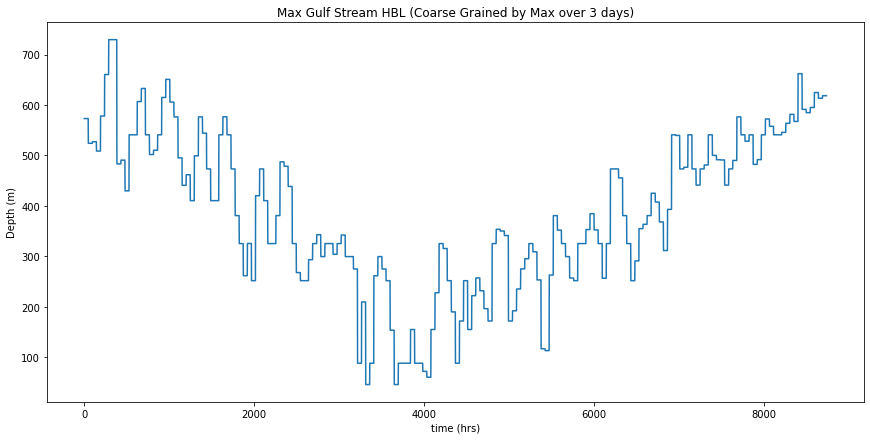

In [37]:
hblm = hbl.max(["lat","lon"])
hblm_cg = coarseGrainHblArray_MAX(hblm, 48)
%matplotlib inline
hblm_cg.plot(aspect=2, size=6)
plt.tight_layout()
plt.xlabel('time (hrs)')
plt.ylabel('Depth (m)')
plt.title('Max Gulf Stream HBL (Coarse Grained by Max over 3 days)')

So Patrice suggested making movies of W T in the bigger region in real space/time domain. He also suggested doing a moving window of length 3 days. This is for 6 months of gulf stream data.

In [3]:
T25 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 25,25 )
T25c = T25.compute()
T25c

Time combined dataset has been opened.
I concatenated the first Z-layer


<xarray.Dataset>
Dimensions:  (lat: 500, lon: 500, time: 4416)
Coordinates:
  * lat      (lat) float64 23.0 23.04 23.08 23.12 ... 42.84 42.88 42.92 42.96
  * lon      (lon) float64 -67.0 -66.96 -66.92 -66.88 ... -47.12 -47.08 -47.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 22.71 22.66 22.67 ... 14.79 14.76 14.69

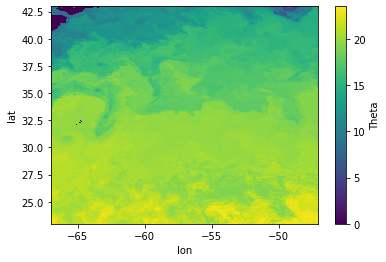

In [4]:
%matplotlib inline
T25c.Theta[0].plot()

Cool, so this is the the right folder! So I can do Zlayers 25,30,35, and maybe 40? We could even do 45.

In [4]:
W25 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 25,25)
W25c = W25.compute()

Time combined dataset has been opened.
I concatenated the first Z-layer


In [6]:
Theta25 = T25c.Theta
W25 = W25c.W
#Theta15_i = Theta15.interp(lon = W15.lon, method = 'linear')
Theta25_reg = regularizeCoordinates(Theta25,'linear',timeunits = 'hours')
W25_reg = regularizeCoordinates(W25, 'linear', timeunits = 'hours')

In [7]:
Qvert25 = Theta25_reg*W25_reg


In [48]:
W15

<xarray.DataArray 'W' (time: 4416, lat: 500, lon: 500)>
array([[[-1.17029795e-05, -1.85027689e-04, -3.19359242e-04, ...,
          6.04467677e-05,  1.30742585e-04, -8.71964294e-05],
        [-1.35519658e-04,  8.36610416e-05,  3.59078142e-04, ...,
         -5.87894931e-04, -2.95990496e-04,  8.84676774e-05],
        [ 5.47596683e-05,  4.64346725e-04,  4.67034057e-04, ...,
         -7.09505519e-04,  2.94872279e-05,  2.30887264e-04],
        ...,
        [ 7.49019673e-04,  1.36818722e-04,  5.38006192e-04, ...,
          7.52024498e-05,  1.28662039e-04,  2.99294537e-04],
        [ 2.13587860e-04,  6.52683957e-04,  5.68631571e-04, ...,
         -4.25830658e-04,  3.64684645e-04,  5.34965715e-04],
        [ 5.99148101e-04,  1.70510306e-04,  2.21256079e-04, ...,
         -3.85991065e-04,  4.65266407e-04,  4.91353916e-04]],

       [[ 6.18936174e-05, -2.12186424e-04, -3.97476630e-04, ...,
         -2.84936483e-04,  1.03739265e-04,  1.98471447e-04],
        [ 2.38471664e-04,  1.90496779e-04,  7.04494159e-05, ...,
         -3.66137188e-04, -4.85875062e-04, -1.54287554e-04],
        [ 2.59043940e-04,  2.97454768e-04,  5.03779374e-05, ...,
         -4.30266868e-04, -3.83616338e-04, -2.72454112e-04],
...
        [-2.51637306e-03, -2.46580411e-03, -8.83909699e-04, ...,
          2.33842311e-05, -2.89539130e-05, -1.50281412e-04],
        [-2.09789164e-03, -1.71129033e-03, -2.87624076e-04, ...,
         -3.34386074e-04, -2.07277189e-05,  1.51404020e-04],
        [-9.41599865e-05, -3.66527296e-04,  5.17249719e-05, ...,
         -3.44147440e-04, -3.61215789e-05,  1.30802873e-04]],

       [[-2.46136478e-05,  2.74096565e-05, -3.23047025e-05, ...,
         -2.55324376e-05, -1.36657807e-04, -5.61824854e-05],
        [-3.62239312e-04, -1.78665679e-04,  1.64319099e-05, ...,
          1.78193106e-04,  3.59162688e-04,  5.72224271e-05],
        [-6.72287773e-04, -2.90853088e-04,  6.41062798e-05, ...,
          7.81558803e-04,  1.16202096e-03,  4.45798389e-04],
        ...,
        [-1.06034824e-03,  9.42254919e-05,  9.30882466e-04, ...,
         -2.48509110e-04, -1.32787856e-04, -3.97558731e-04],
        [-1.37879513e-03, -1.65985560e-03,  3.72046430e-04, ...,
         -2.20195914e-04, -1.70251500e-04, -2.10152968e-04],
        [ 3.59793776e-05, -4.50304273e-04, -1.71510073e-05, ...,
         -1.61401695e-05,  8.43406960e-05, -4.24405698e-05]]])
Coordinates:
  * lat      (lat) float64 23.0 23.04 23.08 23.12 ... 42.84 42.88 42.92 42.96
  * lon      (lon) float64 -67.0 -66.96 -66.92 -66.88 ... -47.12 -47.08 -47.04
Dimensions without coordinates: time

In [49]:
Qvert

<xarray.DataArray (time: 4416, xdim: 500, ydim: 500)>
array([[[-0.00028665, -0.00452795, -0.00781704, ...,  0.00139319,
          0.00300978, -0.0020071 ],
        [-0.00331194,  0.00204648,  0.00878841, ..., -0.01354373,
         -0.00681304,  0.00203584],
        [ 0.00133855,  0.01135727,  0.0114047 , ..., -0.01634197,
          0.00067865,  0.00531414],
        ...,
        [ 0.00664942,  0.00124963,  0.00496072, ...,  0.0008667 ,
          0.00145585,  0.00351428],
        [ 0.00189523,  0.00594189,  0.00520172, ..., -0.00478079,
          0.00405044,  0.00633576],
        [ 0.00529587,  0.00153581,  0.00199346, ..., -0.00420736,
          0.00520455,  0.00591523]],

       [[ 0.00151652, -0.00519311, -0.00972843, ..., -0.00656584,
          0.00238771,  0.00456774],
        [ 0.00582724,  0.00465926,  0.00172419, ..., -0.00843326,
         -0.01118191, -0.00355014],
        [ 0.00633132,  0.00727513,  0.00123067, ..., -0.00990833,
         -0.00882748, -0.00627037],
...
        [-0.03682257, -0.03592102, -0.01275896, ...,  0.00036629,
         -0.00044606, -0.00242085],
        [-0.03052193, -0.02491099, -0.00414148, ..., -0.00511903,
         -0.00033749,  0.0025308 ],
        [-0.0013266 , -0.00527929,  0.00074733, ..., -0.00566836,
         -0.00060054,  0.00215216]],

       [[-0.00062045,  0.00069237, -0.0008185 , ..., -0.00058937,
         -0.00317527, -0.0013403 ],
        [-0.00930106, -0.0045561 ,  0.00041682, ...,  0.00415087,
          0.00841044,  0.00134621],
        [-0.01724193, -0.00741704,  0.00162971, ...,  0.01842485,
          0.02753791,  0.01055715],
        ...,
        [-0.01579365,  0.00137524,  0.01319894, ..., -0.00386558,
         -0.0020616 , -0.0065196 ],
        [-0.02059899, -0.0242833 ,  0.00531554, ..., -0.00342322,
         -0.00280516, -0.0035127 ],
        [ 0.00052821, -0.00655386, -0.00024449, ..., -0.00026756,
          0.00139923, -0.00069481]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 4.413e+03 4.414e+03 4.415e+03
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [8]:
def movingWindowAverage(xarraydata, dim, windowsize):
    chunks = xarraydata.chunk({"xdim": 100, "ydim": 100})
    xavg = chunks / windowsize
    for index in range(1,windowsize):
        if (dim =='time'):
            xavg += chunks.shift(time=-1*index, fill_value = 0) / windowsize
            # add other potential dimensions. xarray.shift doesn't allow us to pick dimensions in an easier way
        else:
            xavg += xavg
        
    return xavg[0:-1*windowsize]

In [9]:
Qvert_winavg_3days = movingWindowAverage(Qvert25, 'time', 72)

In [32]:
Qvert_winavg_3days

<xarray.DataArray (time: 4344, xdim: 500, ydim: 500)>
dask.array<getitem, shape=(4344, 500, 500), dtype=float64, chunksize=(4344, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 4.341e+03 4.342e+03 4.343e+03
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [ ]:
# something like this for making the movieb
from xmovie import Movie
Qvert_winavg_3days_cg = Qvert_winavg_3days[0:-1:12, 0:-1:2, 0:-1:2]#.plot(size=6, aspect=1.4)
mov = Movie(Qvert_winavg_3days_cg.chunk({'time':100}))
mov.save('/nobackup/amondal/NCData/Qmovies/Q25_3daywinavg.mp4', parallel=True)

I'm moving this all to a local python script because jupyter seems to have a hard time with it - the moving window average is quite expensive.